<a href="https://colab.research.google.com/github/davidelgas/DataSciencePortfolio/blob/main/DataSciencePortfolio/Inference_Models%20/Risk_Scoring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Risk Scoring with Decision Tree Classifier


This notebook trains a Decision Tree Classifier to predict risk using synthetic police officer data.
1. Create Synthetic Dataset
2. Pre-process Data
3. Model Training with Train/Test Split
4. Evaluating Model Performance (including Confusion Matrix)
5. Feature Importance
6. Force Plots


In [1]:
# Prepare Enviornment
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, classification_report
import matplotlib.pyplot as plt
!pip install shap
import shap


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 9.2 MB/s eta 0:00:00


In [2]:
# Access to Google Drive
# This seems to propagate credentials better from its own cell

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Set random seed for reproducibility
np.random.seed(42)

# Define the sample size
num_officers = 1000

# Generate synthetic data
officer_data = {
    "Age": np.random.randint(22, 60, num_officers),
    "Arrests": np.random.randint(0, 100, num_officers),
    "Assigned_Area": np.random.choice(["Low-Crime", "Medium-Crime", "High-Crime"], num_officers, p=[0.2, 0.5, 0.3]),
    "Commendations": np.random.randint(0, 10, num_officers),
    "Complaints": np.random.randint(0, 20, num_officers) + np.random.normal(5, 2, num_officers).astype(int),
    "Days_Since_Last_Complaint": np.random.randint(0, 365, num_officers),
    "Department_Type": np.random.choice(["Urban", "Rural", "High-Crime"], num_officers, p=[0.5, 0.3, 0.2]),
    "Disciplinary_Actions": np.random.randint(0, 5, num_officers),  # Number of disciplinary actions
    "Education_Level": np.random.choice(["High School", "Associate Degree", "Bachelor's Degree", "Master's Degree"], num_officers, p=[0.4, 0.3, 0.2, 0.1]),
    "Gender": np.random.choice(["Male", "Female"], num_officers, p=[0.8, 0.2]),
    "Incident_Type_Exposure": np.random.choice(["Low-Risk", "Medium-Risk", "High-Risk"], num_officers, p=[0.4, 0.4, 0.2]),
    "Number_of_Arrests_Made": np.random.randint(10, 200, num_officers),
    "Number_of_Lawsuits": np.random.randint(0, 5, num_officers),
    #"Officer_ID": range(1, num_officers + 1), add back in for person level reproting in Tableau
    "Overtime_Hours": np.random.randint(0, 100, num_officers),
    "Patrol_Hours": np.random.randint(30, 60, num_officers),
    "Rank": np.random.choice(["Officer", "Sergeant", "Lieutenant"], num_officers, p=[0.6, 0.3, 0.1]),
    "Shifts_Worked_Last_Month": np.random.randint(10, 30, num_officers),
    "Shift_Type": np.random.choice(["Day", "Night", "Rotating"], num_officers, p=[0.4, 0.4, 0.2]),
    "Special_Unit_Involvement": np.random.choice([None, "SWAT", "Narcotics", "Gang Unit"], num_officers, p=[0.7, 0.1, 0.1, 0.1]),
    "Time_Since_Last_Training": np.random.randint(0, 36, num_officers),
    "Training_Hours_Completed": np.random.randint(50, 500, num_officers),
    "Training_Session_1": np.random.choice([0, 1], num_officers, p=[1, 0]),  # 100% completed session 1
    "Training_Session_2": np.random.choice([0, 1], num_officers, p=[0.85, 0.15]),  # 85% completed session 2
    "Training_Session_3": np.random.choice([0, 1], num_officers, p=[0.7, 0.3]),  # 70% completed session 3
    "Use_of_Force_Incidents": np.random.randint(0, 10, num_officers) + np.random.normal(2, 1, num_officers).astype(int),
    "Veteran_Status": np.random.choice([0, 1], num_officers, p=[0.85, 0.15]),  # 15% veterans
    "Years_of_Experience": np.random.randint(1, 30, num_officers),
    "Years_on_Current_Assignment": np.random.randint(1, 10, num_officers),
}

# Convert officer_data into a DataFrame
officer_df = pd.DataFrame(officer_data)

# Ensure that Litigation_Occurred is set to 1 for exactly 150 entries (15%)
litigation_counts = 150
officer_df['Litigation_Occurred'] = 0

# Randomly select 150 rows to set Litigation_Occurred to 1
indices = np.random.choice(officer_df.index, litigation_counts, replace=False)
officer_df.loc[indices, 'Litigation_Occurred'] = 1

# Adjusting based on forced correlations to model
# These features are positively correlated
positive_conditions = (
    (officer_df['Complaints'] > 10) |
    (officer_df['Use_of_Force_Incidents'] > 3) |
    (officer_df['Department_Type'] == 'Urban') |
    (officer_df['Disciplinary_Actions'] > 1)  # More disciplinary actions correlate with Litigation_Occurred = 1
)


negative_conditions_hours = (officer_df['Training_Hours_Completed'] > 300)
negative_conditions_sessions = (officer_df['Training_Session_1'] == 1) | (officer_df['Training_Session_2'] == 1) | (officer_df['Training_Session_3'] == 1)
negative_conditions_age = (officer_df['Age'] > 45)

# Adjust Litigation_Occurred based on positive correlations while ensuring it stays at 150 samples
officer_df.loc[positive_conditions & (officer_df['Litigation_Occurred'] == 0), 'Litigation_Occurred'] = 1

# Apply the negative correlation
officer_df.loc[negative_conditions_hours | negative_conditions_sessions | negative_conditions_age, 'Litigation_Occurred'] = 0

# Add random noise to decrease precision, recall, and F1-score as would be true in practice
#num_flips = int(num_officers * 0.30)  # 30% noise
#for _ in range(num_flips):
#    # Randomly choose to flip a 0 to 1 or a 1 to 0
#    if np.random.rand() < 0.5:
#        # Flip a 0 to 1
#        zero_indices = officer_df[officer_df['Litigation_Occurred'] == 0].sample(1).index
#        officer_df.loc[zero_indices, 'Litigation_Occurred'] = 1
#    else:
#        # Flip a 1 to 0
#        one_indices = officer_df[officer_df['Litigation_Occurred'] == 1].sample(1).index
#        officer_df.loc[one_indices, 'Litigation_Occurred'] = 0

# Ensure that the final count of Litigation_Occurred is approximately 150
final_count = officer_df['Litigation_Occurred'].value_counts()
if final_count[1] > litigation_counts:
    excess_count = final_count[1] - litigation_counts
    # Randomly set some of the 1s back to 0
    excess_indices = officer_df[officer_df['Litigation_Occurred'] == 1].sample(excess_count).index
    officer_df.loc[excess_indices, 'Litigation_Occurred'] = 0


print(officer_df['Litigation_Occurred'].value_counts())

officer_df.to_csv('/content/drive/MyDrive/Colab Notebooks/Risk/risk_data.csv', index=False)



Litigation_Occurred
0    850
1    150
Name: count, dtype: int64


## Preprocess Data

In [4]:
df = officer_df

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 29 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Age                          1000 non-null   int64 
 1   Arrests                      1000 non-null   int64 
 2   Assigned_Area                1000 non-null   object
 3   Commendations                1000 non-null   int64 
 4   Complaints                   1000 non-null   int64 
 5   Days_Since_Last_Complaint    1000 non-null   int64 
 6   Department_Type              1000 non-null   object
 7   Disciplinary_Actions         1000 non-null   int64 
 8   Education_Level              1000 non-null   object
 9   Gender                       1000 non-null   object
 10  Incident_Type_Exposure       1000 non-null   object
 11  Number_of_Arrests_Made       1000 non-null   int64 
 12  Number_of_Lawsuits           1000 non-null   int64 
 13  Overtime_Hours               1000 

In [5]:
# Automatically identify object-type columns
categorical_columns = df.select_dtypes(include=['object']).columns

# Apply one-hot encoding to all object-type columns
df_encoded = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

# Convert any remaining True/False values to 1/0
df_encoded = df_encoded.astype(int)

In [6]:
df_encoded.info()
df_encoded.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 37 columns):
 #   Column                              Non-Null Count  Dtype
---  ------                              --------------  -----
 0   Age                                 1000 non-null   int64
 1   Arrests                             1000 non-null   int64
 2   Commendations                       1000 non-null   int64
 3   Complaints                          1000 non-null   int64
 4   Days_Since_Last_Complaint           1000 non-null   int64
 5   Disciplinary_Actions                1000 non-null   int64
 6   Number_of_Arrests_Made              1000 non-null   int64
 7   Number_of_Lawsuits                  1000 non-null   int64
 8   Overtime_Hours                      1000 non-null   int64
 9   Patrol_Hours                        1000 non-null   int64
 10  Shifts_Worked_Last_Month            1000 non-null   int64
 11  Time_Since_Last_Training            1000 non-null   int64
 12  Trainin

,Age,Arrests,Commendations,Complaints,Days_Since_Last_Complaint,Disciplinary_Actions,Number_of_Arrests_Made,Number_of_Lawsuits,Overtime_Hours,Patrol_Hours,...,Education_Level_Master's Degree,Gender_Male,Incident_Type_Exposure_Low-Risk,Incident_Type_Exposure_Medium-Risk,Rank_Officer,Rank_Sergeant,Shift_Type_Night,Shift_Type_Rotating,Special_Unit_Involvement_Narcotics,Special_Unit_Involvement_SWAT
0,50,29,3,7,81,3,189,4,62,33,...,0,1,1,0,0,1,0,0,0,0
1,36,28,5,19,219,4,47,1,90,59,...,0,1,0,0,1,0,0,0,0,0
2,29,48,0,10,157,3,157,4,20,42,...,0,0,1,0,1,0,0,0,0,0
3,42,44,7,23,3,1,181,3,4,41,...,0,1,0,1,0,1,0,0,0,0
4,40,92,6,15,166,3,60,4,34,50,...,0,1,0,0,1,0,0,1,0,0


In [7]:
# Check for class imbalance in the dependent column
df = df_encoded

class_counts = df['Litigation_Occurred'].value_counts()

# Print the class distribution
print(class_counts)

Litigation_Occurred
0    850
1    150
Name: count, dtype: int64


In [8]:
# Balance the data

df = df_encoded

from imblearn.over_sampling import RandomOverSampler
from collections import Counter

# Define the feature set (X) and target (y)
X = df.drop(columns=['Litigation_Occurred'])  # Your feature set
y = df['Litigation_Occurred']  # Your target column

# Instantiate the RandomOverSampler
ros = RandomOverSampler(random_state=42)

# Perform the oversampling to balance the classes
X_resampled, y_resampled = ros.fit_resample(X, y)

# Combine the resampled features and target back into a DataFrame
df_resampled = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.DataFrame(y_resampled, columns=['Litigation_Occurred'])], axis=1)

# Check the new class distribution
print("New class distribution after oversampling:")
print(Counter(y_resampled))


New class distribution after oversampling:
Counter({0: 850, 1: 850})


## Train Logistic Regression and Evaluate with Confusion Matrix

In [9]:
df = df_resampled

# Define the feature set (X) and target (y)
X = df.drop(columns=['Litigation_Occurred'])  # Your feature set
y = df['Litigation_Occurred']  # Your target column

# Perform the train/test split
from sklearn.model_selection import train_test_split

# Split the data into 70% training and 30% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Display the shapes of the training and testing sets
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (1190, 36)
X_test shape: (510, 36)
y_train shape: (1190,)
y_test shape: (510,)


In [10]:
# Instantiate the Logistic Regression model
model = LogisticRegression(solver='liblinear', random_state=42)

# Fit the model on the training data
model.fit(X_train, y_train)

# Predict probabilities (risk scores) for the test set
risk_scores = model.predict_proba(X_test)[:, 1]  # Probability of class 1

# Add the risk scores to your test data
X_test['risk_score'] = risk_scores

# Evaluate the model
# Optionally, you can threshold the risk score to generate class predictions
y_pred = (risk_scores > 0.5).astype(int)

# Print classification report
print(classification_report(y_test, y_pred))

# Print AUC score
auc = roc_auc_score(y_test, risk_scores)
print(f"AUC Score: {auc}")

# Optionally, display the risk scores
print(X_test[['risk_score']].head())


              precision    recall  f1-score   support

           0       0.93      0.87      0.90       255
           1       0.88      0.94      0.91       255

    accuracy                           0.91       510
   macro avg       0.91      0.91      0.91       510
weighted avg       0.91      0.91      0.91       510

AUC Score: 0.9533410226835832
      risk_score
1431    0.986465
820     0.252215
33      0.900846
1626    0.956110
702     0.049503


## Feature Importance

In [11]:
# Ensure that X_test has the same columns as X_train
X_test = X_test[X_train.columns]

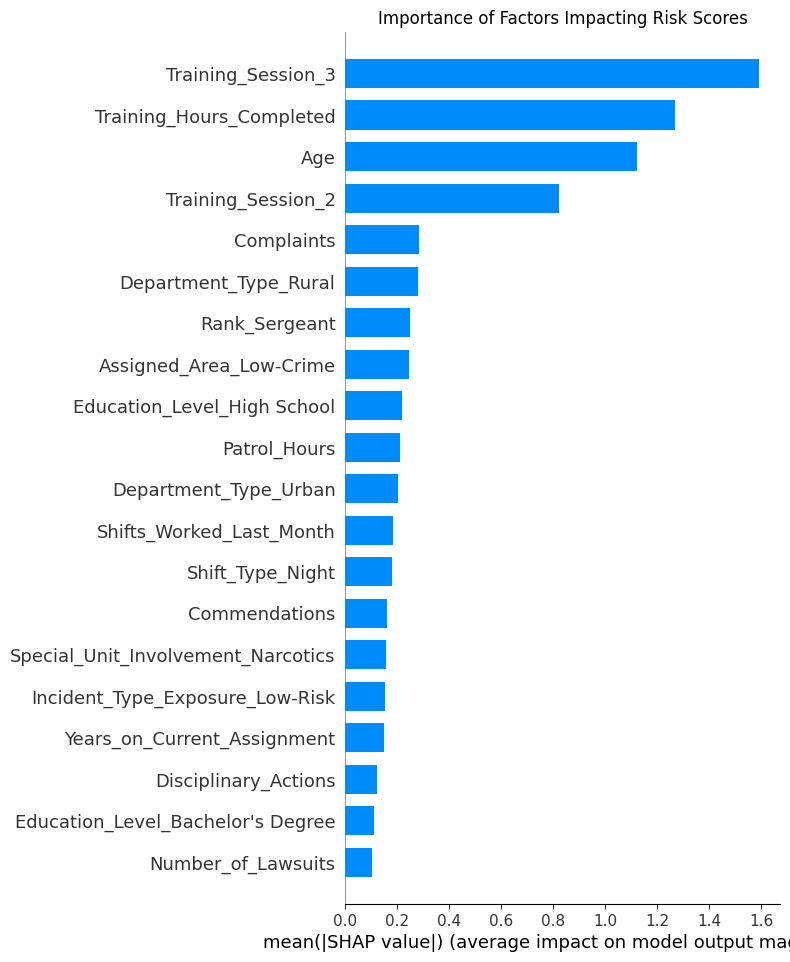

In [12]:
import shap
import matplotlib.pyplot as plt

# Create a SHAP explainer for the Logistic Regression model
explainer = shap.LinearExplainer(model, X_train)

# Calculate SHAP values for the test data
shap_values = explainer.shap_values(X_test)  # Use X_test here

# If shap_values is not a list, use the single shap_values array
if isinstance(shap_values, list):
    shap_values_class_1 = shap_values[1]  # SHAP values for class 1 (Litigation_Occurred = 1)
else:
    shap_values_class_1 = shap_values  # SHAP returns a single array for binary classification

# Create a figure and axes
plt.figure()

# Display SHAP summary plot for class 1 to visualize feature importance
shap.summary_plot(shap_values_class_1, X_test, plot_type="bar", show=False)

# Add a title using matplotlib
plt.title("Importance of Factors Impacting Risk Scores")

# Display the plot with the title
plt.show()


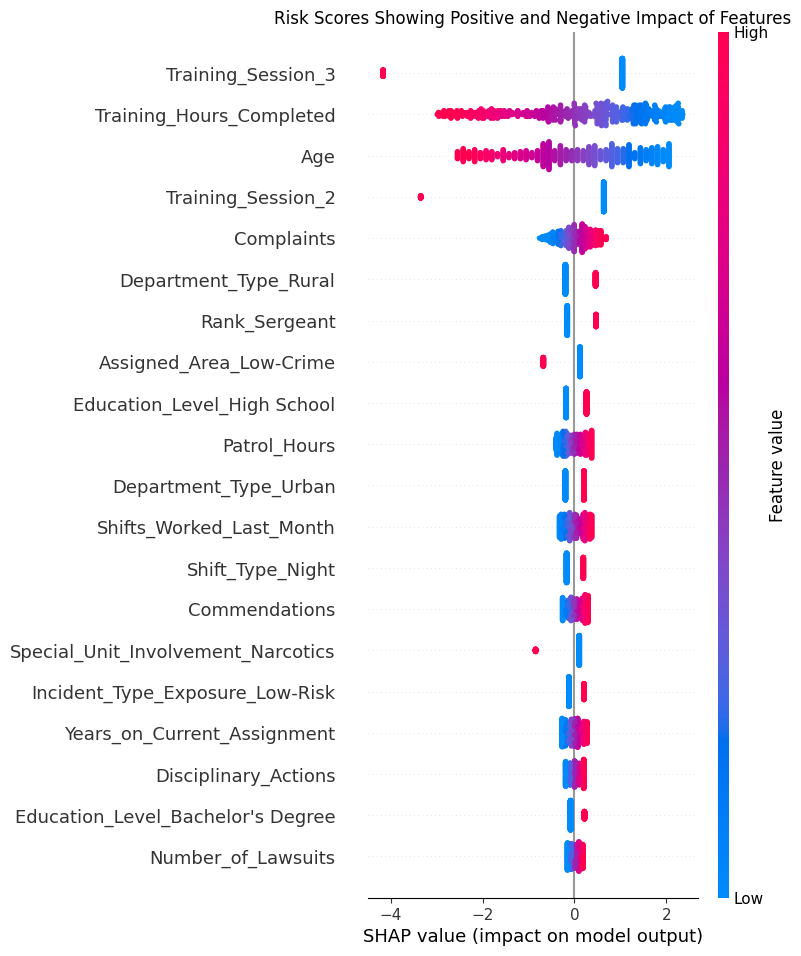

In [13]:

# Assuming the model is already trained and X_test_features is your feature set

# Create SHAP explainer for your model
explainer = shap.LinearExplainer(model, X_train)  # For logistic regression, use LinearExplainer

# Calculate SHAP values for the test data
shap_values = explainer.shap_values(X_test)

# If shap_values is not a list, use the single shap_values array
if isinstance(shap_values, list):
    shap_values_class_1 = shap_values[1]  # SHAP values for class 1 (Litigation_Occurred = 1)
else:
    shap_values_class_1 = shap_values  # SHAP returns a single array for binary classification

# Create a figure before adding a title
plt.figure()

# Generate the SHAP summary beeswarm plot (like the one in the image)
shap.summary_plot(shap_values_class_1, X_test, show=False)

# Add a title using matplotlib
plt.title("Risk Scores Showing Positive and Negative Impact of Features")

# Optionally, save the plot if needed
plt.savefig('shap_beeswarm_plot.png')

# Show the plot
plt.show()


## Force plot showing how features combine for a net risk score

In [14]:
# Select a specific row for which you want to generate the force plot
# Each row is a person (synthetic)
# Example: row_idx = 10 is a very low risk score due to completion of training




shap.initjs()

explainer = shap.LinearExplainer(model, X_train)

shap_values = explainer.shap_values(X_test)


row_idx = 10  # You can change this to any row index you want to experiment
shap_value_for_row = shap_values[row_idx]  # SHAP values for the selected row/person

# Generate the force plot for the selected row
shap.force_plot(explainer.expected_value, shap_value_for_row, X_test.iloc[row_idx])


In [15]:
# Select a specific row for which you want to generate the force plot
# Each row is a person (synthetic)
# Example: row_idx = 11 is a high risk score due to age and lack of Training Session 3 and 2 and general low training hours


shap.initjs()

explainer = shap.LinearExplainer(model, X_train)

shap_values = explainer.shap_values(X_test)


row_idx = 11  # You can change this to any row index you want to experiment
shap_value_for_row = shap_values[row_idx]  # SHAP values for the selected row/person

# Generate the force plot for the selected row
shap.force_plot(explainer.expected_value, shap_value_for_row, X_test.iloc[row_idx])


In [16]:
# Export the data for Tableau Dashboard

# Calculate risk scores (probabilities) for the entire dataset
risk_scores = model.predict_proba(X)[:, 1]  # Predict the probability of 'Litigation_Occurred = 1'

# Add the risk scores to the original DataFrame
df['risk_score'] = risk_scores

# Export the DataFrame with risk scores to a CSV file
df.to_csv('/content/drive/MyDrive/Colab Notebooks/Risk/data_with_risk_scores.csv', index=False)

print(df.head())


   Age  Arrests  Commendations  Complaints  Days_Since_Last_Complaint  \
0   50       29              3           7                         81   
1   36       28              5          19                        219   
2   29       48              0          10                        157   
3   42       44              7          23                          3   
4   40       92              6          15                        166   

   Disciplinary_Actions  Number_of_Arrests_Made  Number_of_Lawsuits  \
0                     3                     189                   4   
1                     4                      47                   1   
2                     3                     157                   4   
3                     1                     181                   3   
4                     3                      60                   4   

   Overtime_Hours  Patrol_Hours  ...  Incident_Type_Exposure_Low-Risk  \
0              62            33  ...                         